# Imports

In [1]:
import pandas as pd
import numpy as np
import os,  sys
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mtick

from mpl_toolkits import mplot3d

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from hetanalysis import HetAnalysis
from clean import PCBCCleaner
import plotter

output_dir = "../outputs/het_analysis_wrt_time_pcbc/"
SAVE = False

# %matplotlib widget

# Data Input and Cleaning

In [2]:
df = PCBCCleaner.get_processed_data()

# Group and Output

## Test

### Group

In [3]:
dhids = list(df['dhid'].unique())

In [5]:
dhid = 'P20-10E'

elements = [
    'CU',
    'AU'
]

dp_timeslices = {}

filtered_df = df.query('dhid == @dhid').dropna(subset=elements).reset_index(drop=True)

indices = filtered_df.index.to_list()

ig = {}
for index in indices:
    dp_timeslices[index] = {}
    
    for element in elements:
        if element not in ig:
            ig[element] = []
        ig[element].append(filtered_df[element].loc[index])
        
        dp_timeslices[index][element] = HetAnalysis(
            f'{dhid}_{element}_{index}', 
            filtered_df['weight'].loc[:index], 
            filtered_df[element].loc[:index]
            )
        
        

In [6]:
w, h, g = [], [], []
for date, timeslice in dp_timeslices.items():
    w.append(timeslice['CU'].get_cml_weight())
    h.append(timeslice['CU'].get_heterogeneity())
    g.append(timeslice['CU'].get_grade())

### Output

Text(0.5, 1.0, 'P20-10E Grade/Heterogeneity wrt to Weight')

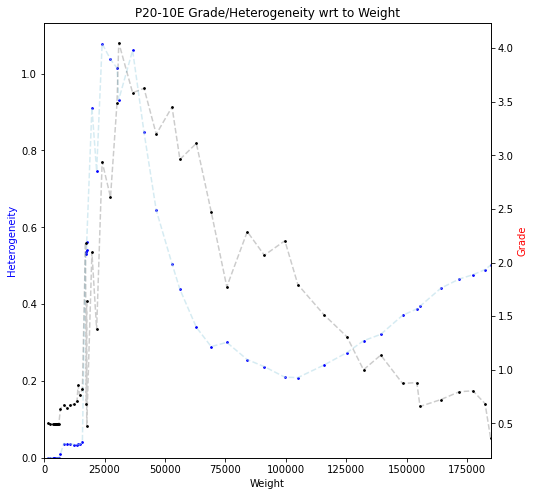

In [8]:
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = fig.add_subplot()

ax.plot(w, h, alpha=0.5, c='lightblue', ls='--')
ax.scatter(w, h, c='blue', s=3)

ax.set_xlim(0, max(w))
ax.set_xlabel('Weight')

ax.set_ylim(0)
ax.set_ylabel('Heterogeneity', c='blue')

sec_ax = ax.twinx()

sec_ax.plot(w, g, alpha=0.2, c='red', ls='--')
sec_ax.scatter(w, g, c='red', s=3)

# sec_ax.plot(w, ig['CU'], alpha=0.2, c='black', ls='--')
# sec_ax.scatter(w, ig['CU'], c='black', s=3)

sec_ax.set_ylabel('Grade', c='red')

ax.set_title(f'{dhid} Grade/Heterogeneity wrt to Weight')

## Grouping

In [21]:
groups = {}

elements = [
    'CU',
    'AU'
]

for dhid in dhids:
    filtered_df = df.query('dhid == @dhid').dropna().reset_index(drop=True)
    
    # Should have no dhs without data
    # if filtered_df.isnull().all():
    #     print(f"No data for {dhid}")
    
    dp_timeslices = {}
    
    indices = filtered_df.index.to_list()
    
    for index in indices:
        dp_timeslices[index] = {}
        
        for element in elements:
            dp_timeslices[index][element] = HetAnalysis(
                f'{dhid}_{element}_{index}', 
                filtered_df['weight'].loc[:index], 
                filtered_df[element].loc[:index]
                )
    
    groups[dhid] = dp_timeslices

## Output

Output H-G wrt T Graphs

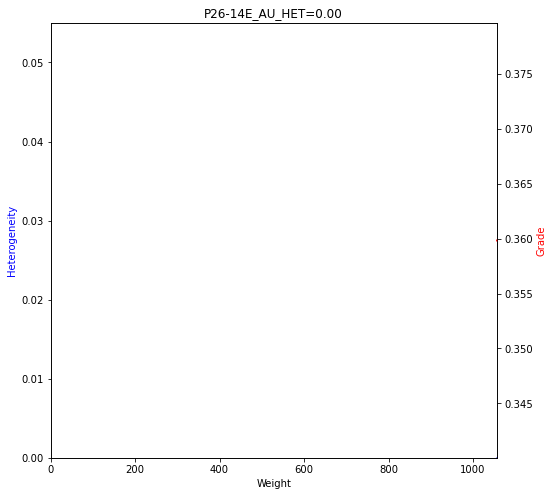

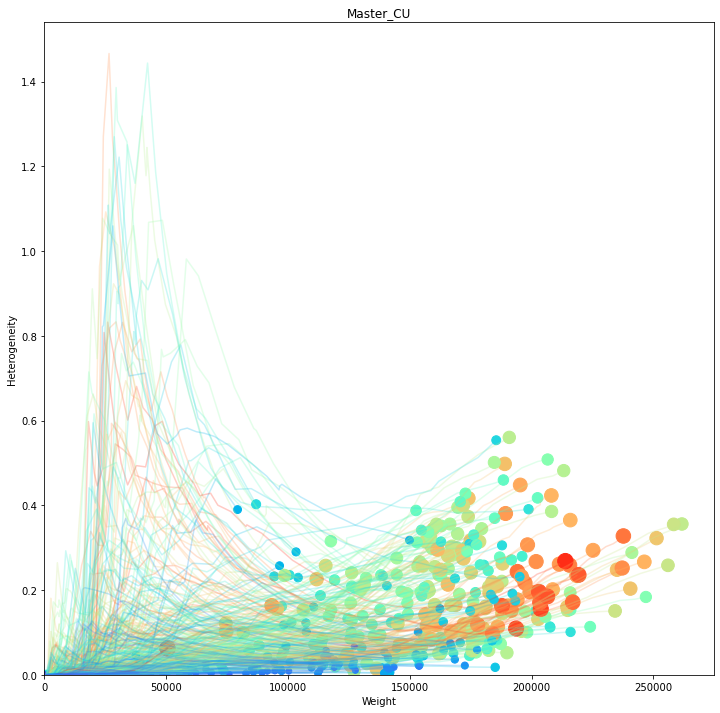

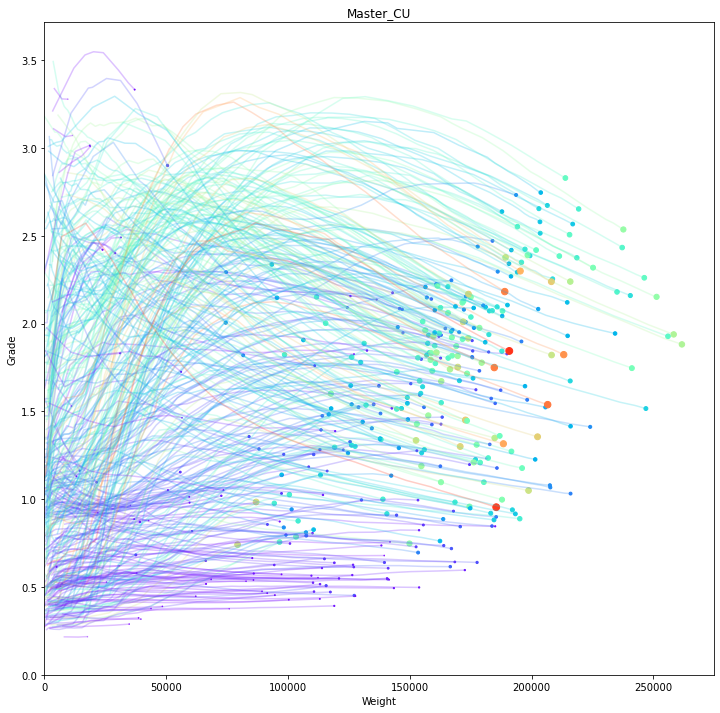

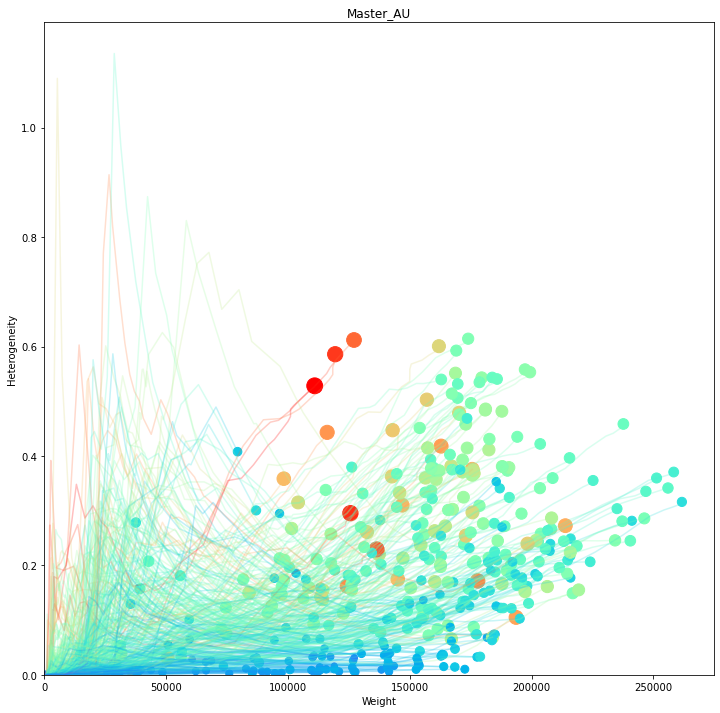

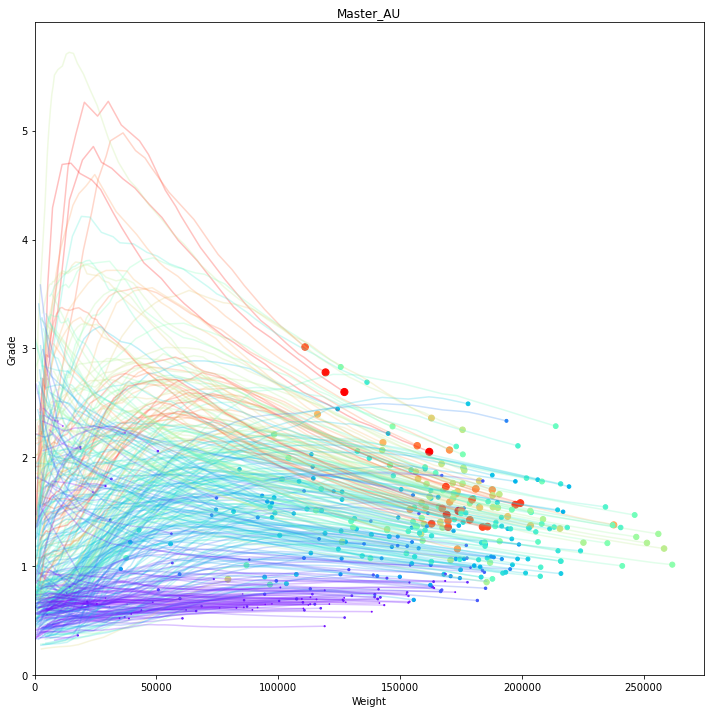

In [23]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    
    s = 3
    alpha = 0.5
    
    ms = 0.5
    ma = 0.25
    
    cmap = plt.colormaps.get('rainbow')
    g_norm = colors.Normalize(vmin=0.0, vmax=3.0)
    h_norm = colors.Normalize(vmin=0.0, vmax=0.6)
    
    for element in elements:
        hw_master_fig = plt.figure()
        hw_master_fig.set_size_inches(12, 12)
        hw_master_ax = hw_master_fig.add_subplot()
        
        hw_master_ax.set_xlabel('Weight')
        hw_master_ax.set_ylabel('Heterogeneity')
        
        # hw_master_ax.set_facecolor('black')
        hw_master_ax.set_title(f'Master_{element}')
        
        gw_master_fig = plt.figure()
        gw_master_fig.set_size_inches(12, 12)
        gw_master_ax = gw_master_fig.add_subplot()
        
        gw_master_ax.set_xlabel('Weight')
        gw_master_ax.set_ylabel('Grade')
        
        # gw_master_ax.set_facecolor('lightgrey')
        gw_master_ax.set_title(f'Master_{element}')
        
        wf, hf, gf = [], [], []
        
        for dhid, dp_timeslices in groups.items():
            save_loc = output_dir + f'{dhid}/'
            if not os.path.exists(save_loc):
                os.makedirs(save_loc)
            
            fig.clear()
            ax = fig.add_subplot()

            w, h, g = [], [], []
            for date, timeslice in dp_timeslices.items():
                w.append(timeslice[element].get_cml_weight())
                h.append(timeslice[element].get_heterogeneity())
                g.append(timeslice[element].get_grade())
            wf.append(w[-1])
            hf.append(h[-1])
            gf.append(g[-1])
            
            if len(w) > 0:
                ax.plot(w, h, alpha=alpha, c='blue', ls='--')
                ax.scatter(w, h, c='blue', s=s)

                ax.set_xlim(0, max(w))
                ax.set_xlabel('Weight')

                ax.set_ylim(0)
                ax.set_ylabel('Heterogeneity', c='blue')

                sec_ax = ax.twinx()

                sec_ax.plot(w, g, alpha=alpha, c='red', ls='--')
                sec_ax.scatter(w, g, c='red', s=s)

                sec_ax.set_ylabel('Grade', c='red')

                ax.set_title(f'{dhid}_{element}_HET={h[-1]:.2f}')
                fig.savefig(save_loc + f'{dhid}_{element}.svg', format='svg')
                
                # Add to masters
                final_g = g[-1]
                hw_master_ax.plot(w, h, c=cmap(g_norm(final_g)), alpha=ma)
                # hw_master_ax.scatter(w, h, c='black', s=ms, alpha=ma)
                
                final_h = h[-1]
                gw_master_ax.plot(w, g, c=cmap(h_norm(final_h)), alpha=ma)
                # gw_master_ax.scatter(w, g, c='black', s=ms, alpha=ma)
    
        hw_master_ax.scatter(wf, hf, color=cmap(g_norm(gf)), s=100*ms*g_norm(gf))
        
        hw_master_ax.set_xlim(0)
        hw_master_ax.set_ylim(0)
        
        gw_master_ax.scatter(wf, gf, color=cmap(h_norm(hf)), s=100*ms*h_norm(hf))
        
        gw_master_ax.set_xlim(0)
        gw_master_ax.set_ylim(0)
    
        save_loc = output_dir + f'master/'    
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)      
        hw_master_fig.savefig(save_loc + f'hw_master_{element}.svg', format='svg')
        gw_master_fig.savefig(save_loc + f'gw_master_{element}.svg', format='svg')

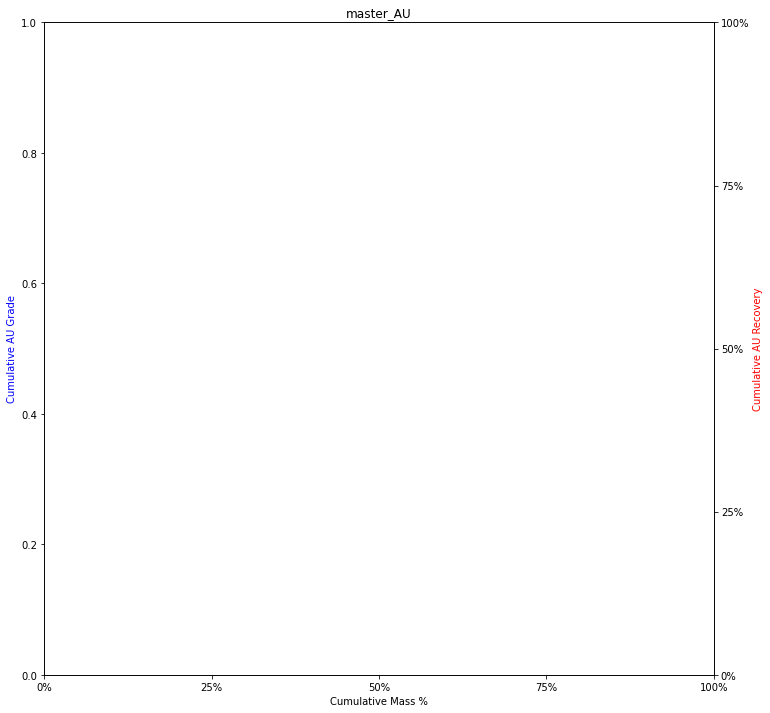

In [30]:
# then we want to graph the mass yield curves for all the individual elements
no_of_graphs = len(elements)

if SAVE:
    fig = plt.figure()
    fig.set_size_inches(12, 12)

    s = 0.5
    alpha = 0.4

    for element in elements:
        fig.clear()
        ax = fig.add_subplot()
        ax_sec = ax.twinx()
        
        for dhid, drillhole in groups.items():
            if element in drillhole:
                plotter.scatter_g_r(ax, ax_sec, drillhole.resources[element].get_info(), s=s, alpha=alpha)
                
        plotter.set_g_r_labels(ax, ax_sec, element)
        ax.set_title(f'master_{element}')

        save_loc = output_dir + f'master/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
        fig.savefig(save_loc + f'master_{element}.png', format='png', dpi=200)

In [ ]:
combined_data = {}

for element in elements:
    combined_data[element] = HetAnalysis(
        f'combined_{element}_{index}', 
        filtered_df['weight'].loc[:index], 
        filtered_df[element].loc[:index]
    )

In [31]:
combined_data = Grouping('combined_data')
flat_draw_tons = draw_tons.to_numpy().flatten()
combined_data.add_resource("CU", flat_draw_tons, cu_pcbc.to_numpy().flatten())
combined_data.add_resource("AU", flat_draw_tons, au_pcbc.to_numpy().flatten())

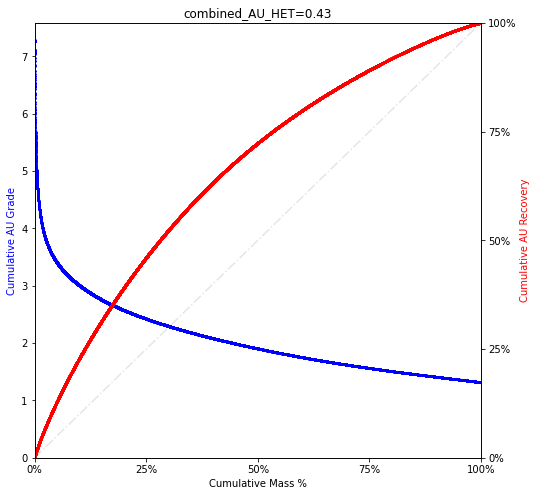

In [32]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(8, 8)

    for element in elements:
        fig.clear()
        ax = fig.add_subplot()

        het = combined_data.resources[element].get_heterogeneity()
        df = combined_data.resources[element].get_info()
            
        if len(df) > 0:
            ax.set_title(f'combined_{element}_HET={het:.2f}')
            plotter.plot_grade_recovery_curve(ax, df, element)

            save_loc = output_dir + f'combined/'
            if not os.path.exists(save_loc):
                os.makedirs(save_loc)
            fig.savefig(save_loc + f'combined_{element}.png', format='png', dpi=200)

# Visualize

In [36]:
dp_coords = dp_coords.rename(
    columns={
        "Draw Point Name": "name", 
        "X-dpt": "x",
        'Y-dpt': 'y',
        'Z-dpt': 'z'
    }
)
dp_coords = dp_coords.set_index('name')

In [37]:
for dhid, group in groups.items():
    if dhid not in list(dp_coords.index):
        print('dhid')

In [39]:
hs = {}
for dpid in list(dp_coords.index):
    if dpid not in groups:
        for element in elements:
            if element not in hs:
                hs[element] = []
            hs[element].append(np.nan)
    else:
        dp = groups[dpid]
        for element in elements:
            if element not in hs:
                hs[element] = []
            if not dp:
                hs[element.append(np.nan)]
            else:
                if element in dp.resources:
                    dhr = dp.resources[element]
                    hs[element].append(dp.resources[element].get_heterogeneity())
                else:
                    hs[element].append(np.nan)

AttributeError: 'dict' object has no attribute 'resources'

In [ ]:
# %matplotlib qt


# fig = plt.figure()
# ax = plt.axes(projection='3d')

# element = 'CU'

# h = np.array(hs[element])

# # ax.scatter3D(
# #     dp_coords['x'], 
# #     dp_coords['y'], 
# #     dp_coords['z'],
# #     s=1,
# #     alpha=0.5,
# #     c='grey'
# # )
# # ax.set_title(element)
# # ax.set_xlabel('x')
# # ax.set_ylabel('y')
# # ax.set_zlabel('z')

# x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

# col = []
# # cmap = colors.Colormap('viridis')

# import matplotlib
# cmap = matplotlib.cm.get_cmap('viridis')

# ch = np.array(h)
# ch = ch[~np.isnan(ch)]
# percentile90 = np.quantile(ch, 0.97)
# print(percentile90)
# def normalize(i: float):
#     return i / percentile90

# for het in h:
#     if not np.isnan(het):
#         col.append(cmap(normalize(het)))
#     else:
#         col.append((0.7, 0.7, 0.7, 0.1))

# # col = np.where(np.isnan(h), 'red', h)
# # ma_h = np.ma.array(h, mask=np.isnan(h))
# # cmap = plt.get_cmap('viridis').copy()
# # cmap.set_bad('grey',1.)

# p = ax.scatter3D(
#     x, 
#     y,
#     z, 
#     c=col,
#     # cmap=cmap,
#     s=40,
#     alpha=1
# )
# ax.set_title(element)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# # ax.set_zlim([2550, 2650])
# fig.colorbar(p)

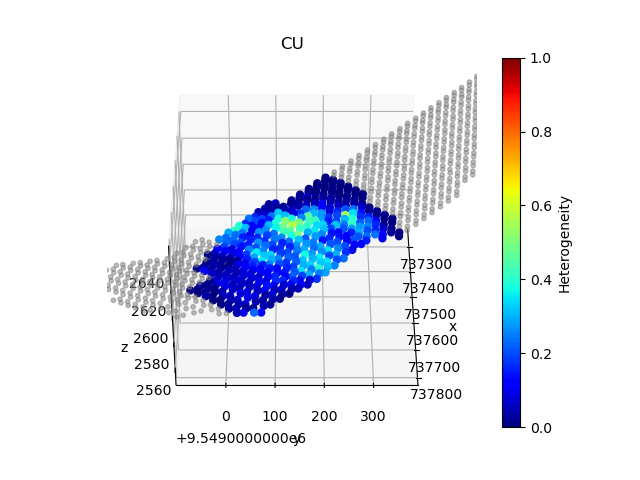

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

h = np.array(hs[element])
x, y, z = dp_coords['x'], dp_coords['y'], dp_coords['z']

cmap = plt.colormaps.get('winter')
nan = np.argwhere(np.isnan(h))

p = ax.scatter3D(
    x, 
    y,
    z, 
    c=h,
    vmax=1,
    cmap=cmap,
    s=25,
    alpha=1
)

# Set limits to the non-nan values
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_zlim([2550, 2650])


nan = np.argwhere(np.isnan(h))
nan = nan.flatten()
ax.scatter3D(
    x[nan], 
    y[nan], 
    z[nan],
    s=10,
    alpha=0.5,
    c='grey'
)

ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.azim = 0
ax.elev = 40

# id = 'P08-04W'
# ax.scatter(x[id], y[id], z[id], marker='*', c='red', s=100)

cbar = fig.colorbar(p)
cbar.set_label('Heterogeneity')

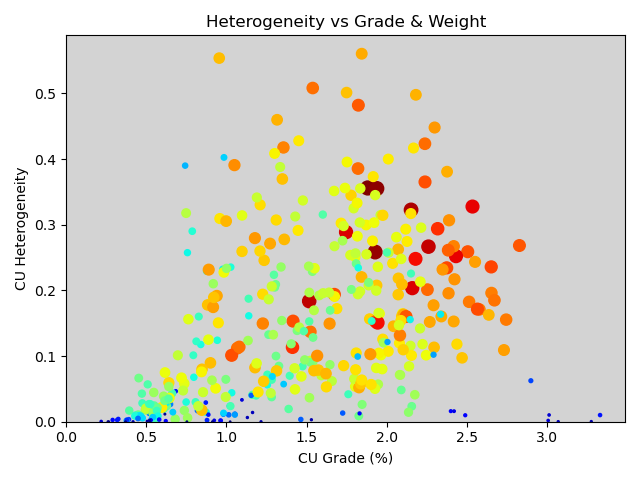

In [ ]:
element = 'CU'

x, y, w = [], [], []

for dhid, group in groups.items():
    x.append(group.resources[element].get_grade())
    y.append(group.resources[element].get_heterogeneity())
    w.append(group.resources[element].get_cml_weight())
    
max_w = np.max(w)
scaled_w = 1 + (9 * (w / max_w))


fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, s=scaled_w**2, c=w, cmap=plt.colormaps.get('winter'))

ax.set_xlabel(f'{element} Grade (%)')
ax.set_xlim(0, None)

ax.set_ylabel(f'{element} Heterogeneity')
ax.set_ylim(0, None)

ax.set_title('Heterogeneity vs Grade & Weight')
ax.set_facecolor('lightgrey')

fig.tight_layout()

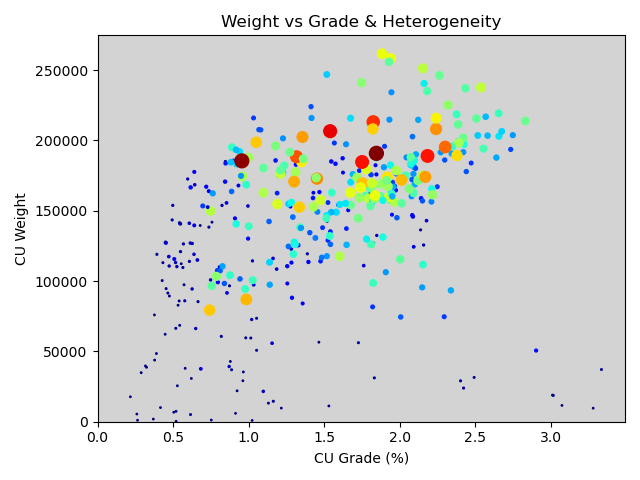

In [ ]:
element = 'CU'

x, y, h = [], [], []

for dhid, group in groups.items():
    x.append(group.resources[element].get_grade())
    y.append(group.resources[element].get_cml_weight())
    h.append(group.resources[element].get_heterogeneity())
    
max_h = np.max(h)
scaled_h = 1 + (9 * (h / max_h))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, s=scaled_h**2, c=h, cmap=plt.colormaps.get('winter'))

ax.set_xlabel(f'{element} Grade (%)')
ax.set_xlim(0, None)

ax.set_ylabel(f'{element} Weight')
ax.set_ylim(0, None)

ax.set_title('Weight vs Grade & Heterogeneity')
ax.set_facecolor('lightgrey')

fig.tight_layout()

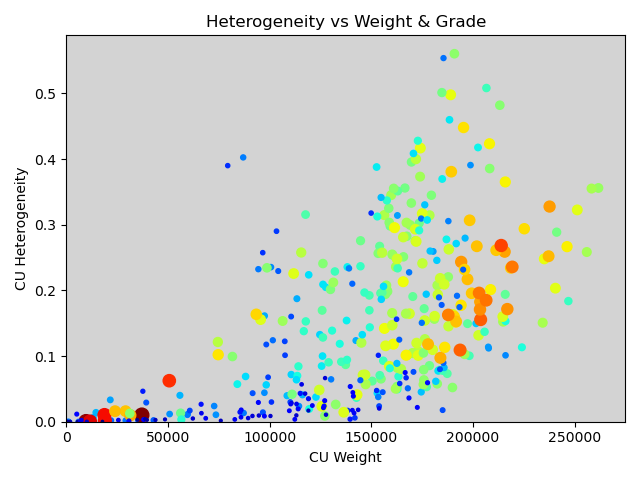

In [ ]:
element = 'CU'

x, y, g = [], [], []

for dhid, group in groups.items():
    x.append(group.resources[element].get_cml_weight())
    y.append(group.resources[element].get_heterogeneity())
    g.append(group.resources[element].get_grade())
    
max_g = np.max(g)
scaled_g = 1 + (9 * (g / max_g))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, s=scaled_g**2, c=g, cmap=plt.colormaps.get('winter'))

ax.set_xlabel(f'{element} Weight')
ax.set_xlim(0, None)

ax.set_ylabel(f'{element} Heterogeneity')
ax.set_ylim(0, None)

ax.set_title('Heterogeneity vs Weight & Grade')
ax.set_facecolor('lightgrey')

fig.tight_layout()